In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [7]:
X_test.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9394,9395,15615753,Upchurch,597,Germany,Female,35,8,131101.04,1,1,1,192852.67,0
898,899,15654700,Fallaci,523,France,Female,40,2,102967.41,1,1,0,128702.10,1
2398,2399,15633877,Morrison,706,Spain,Female,42,8,95386.82,1,1,1,75732.25,0
5906,5907,15745623,Worsnop,788,France,Male,32,4,112079.58,1,0,0,89368.59,0
2343,2344,15765902,Gibson,706,Germany,Male,38,5,163034.82,2,1,1,135662.17,0


In [8]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
    

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [10]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
# Добавляем
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler(cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

C:\Users\YAShmarin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass copy=CreditScore as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\YAShmarin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass copy=Age as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\YAShmarin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass copy=Balance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\YAShmarin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass copy=NumOfProducts as keyword args. From version 0.25 passing these as positional argume

In [16]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [102]:
pipeline_LR = Pipeline([
    ('features',feats),
    ('regressor', LogisticRegression(random_state = 42, class_weight={0:1,1:4})),
])

In [103]:
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [104]:
#наши прогнозы для тестовой выборки
preds_LR = pipeline_LR.predict_proba(X_test)[:, 1]
preds_LR[:10]

array([0.54252121, 0.6605468 , 0.43281339, 0.3250377 , 0.4481445 ,
       0.88935171, 0.2206363 , 0.27328402, 0.74252673, 0.93502316])

In [26]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [105]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_LR)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.570240, F-Score=0.515, Precision=0.427, Recall=0.648


In [33]:
# Используем модель бустинга
from sklearn.linear_model import SGDClassifier

In [110]:
pipeline_SGD = Pipeline([
    ('features',feats),
    ('regressor', SGDClassifier(loss='log', random_state = 42, class_weight={0:1,1:4})),
])

In [111]:
pipeline_SGD.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [113]:
#наши прогнозы
preds_SGD = pipeline_SGD.predict_proba(X_test)[:, 1]
preds_SGD[:10]

array([0.5469591 , 0.7781855 , 0.46569625, 0.37664872, 0.36318676,
       0.88427365, 0.16438557, 0.1720025 , 0.77449739, 0.94007258])

In [114]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test, preds_SGD)

fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)
# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

Best Threshold=0.626059, F-Score=0.506, Precision=0.445, Recall=0.587


Для определения наиболее важной DS-метрики, всё-таки, нужно понимать стоимость потери/удержания. Предположим, что потерять гораздо дороже - 
тогда важнее будет ориентироваться на полноту.
В таком случае наиболее выгодной будет модель с регрессией.

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1549  442]
 [ 180  329]]


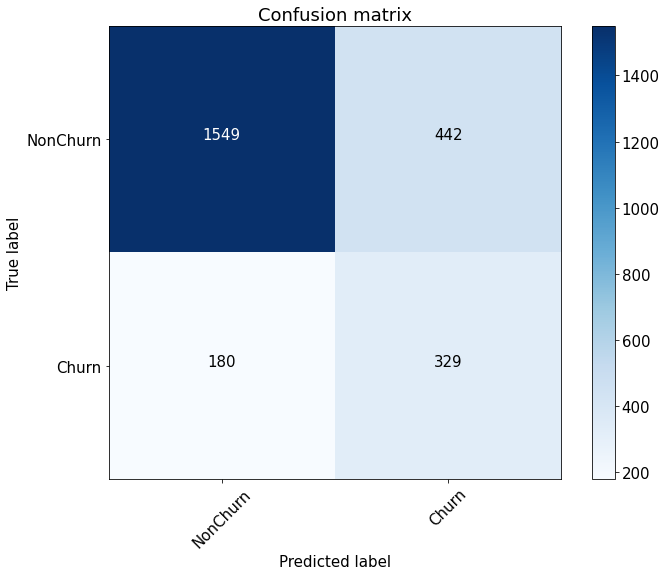

In [81]:
#делаем матрицу по регрессии
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_LR = confusion_matrix(y_test, preds_LR>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_LR, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
def TP_FP_ev(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

   # TPR = TP/(TP+FN)
   # FPR = FP/(FP+TN)
   # TNR = TN/(FP+TN)
    return TP, FP, TN, FN

In [82]:
TPl, FPl, TNl, FNl = TP_FP_ev(cnf_matrix_LR)

In [83]:
# на всех, кого определили как уходящих тратим 1 руб
cost = (TPl+FPl)*1
# c тех, кто действительно собирался уходить получаем ещё 2 руб
benefit = TPl*2

goal = benefit - cost
print('Экономический эффект:', goal, 'руб.')

Экономический эффект: -113 руб.


Экономический эффект отрицательный - эксперимент не целесообразен.
С другой стороны, мы видим, что более подходящей DS-метрикой будет точность, а не полнота.

Confusion matrix, without normalization
[[1618  373]
 [ 211  298]]


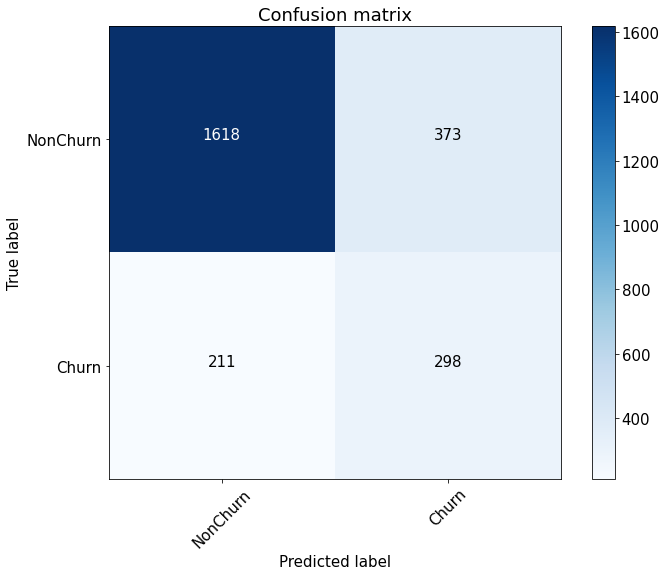

In [115]:
#делаем матрицу по регрессии
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_SGD = confusion_matrix(y_test, preds_SGD>thresholds2[ix2])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_SGD, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [116]:
TPb, FPb, TNb, FNb = TP_FP_ev(cnf_matrix_SGD)

In [117]:
# на всех, кого определили как уходящих тратим 1 руб
cost2 = (TPb+FPb)*1
# c тех, кто действительно собирался уходить получаем ещё 2 руб
benefit2 = TPb*2

goal2 = benefit2 - cost2
print('Экономический эффект:', goal2, 'руб.')

Экономический эффект: -75 руб.
